## MOVIES GENRES

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.linear_model import LinearRegression

import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
from statsmodels.formula.api import ols
import pingouin as pg
from scipy.stats import kruskal
from scipy.stats import shapiro
%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *
from src.utils.appendix import *
import statsmodels.api as sms
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocess_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)
preprocessed_movies = pd.read_csv(processed_data_path)

In [3]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.zip")
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
cleaned_events = preprocess_events(raw_history_data, first_movie_year, last_movie_year)
events_countries = cleaned_events['Country'].unique()
movies_countries = preprocessed_movies['Countries'].str.split(', ').explode().unique()
#Elements in events_countries that are not in movies_countries
not_in_movies_dataset = [item for item in events_countries if item not in movies_countries]
cleaned_events = cleaned_events[cleaned_events['Country'].isin(movies_countries)]
preprocessed_history = cleaned_events.copy()

In this section, we will examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [4]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")

There are 362 genres in the dataset


Movies are classified into a wide variety of genres that reflect themes, styles, cultural contexts, narrative forms, or settings. However, not all of these dimensions are directly relevant to our analysis, so it is necessary to select genres that enable meaningful grouping of films.

There are several approaches we could take to group movies:
1. Select the most popular genres.
2. Identify correlations between genres to consolidate them into broader categories.
3. Manually select the genres most relevant to our analysis.

We will explore the first two options, and if they prove insufficient, we will resort to the third approach, which remains feasible given that manually handling 300 genres is manageable.

#### 1) Most Popular Genre

Number of genres assigned to more than 50 movies: 196.


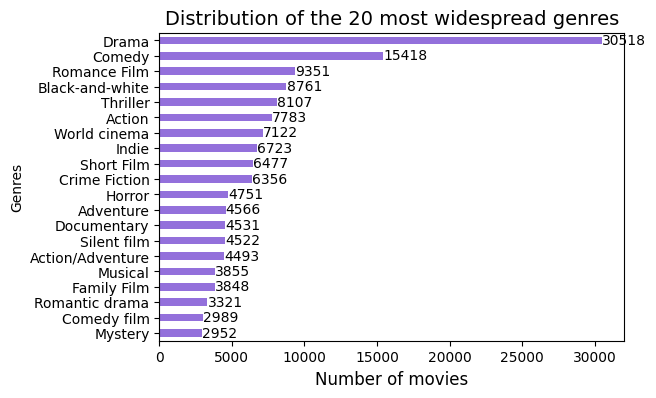

In [5]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()

#Only keep genres that have been assigned to more than 50 movies
threshold = 50
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than {threshold} movies: {len(relevant_genres)}.")

#20 most widespread genres
top_20_genres = relevant_genres.head(20)

plt.figure(figsize=(6, 4))
top_20_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=12)
plt.title('Distribution of the 20 most widespread genres', fontsize=14)
plt.gca().invert_yaxis() 

for index, value in enumerate(top_20_genres):
    plt.text(value + 10, index, str(value), va='center')
plt.show()

Many genres in the dataset may not be meaningful for our analysis because they contain very few movies, making it difficult to observe any trends over time for these genres. To focus on relevant genres, we can set an arbitrary threshold for the minimum number of movies assigned to each genre.

We also reviewed the top 20 genres to examine their distribution and identify which ones might be significant.

One immediate observation is that the genres are not inherently comparable, as they often describe entirely different aspects of a film. For example, comparing trends between "Black-and-White Film" and "Comedy" is problematic. The former describes a technical characteristic, while the latter defines the tone or mood of a film, and these categories are not mutually exclusive. A film can be both a black-and-white film and a comedy simultaneously. 

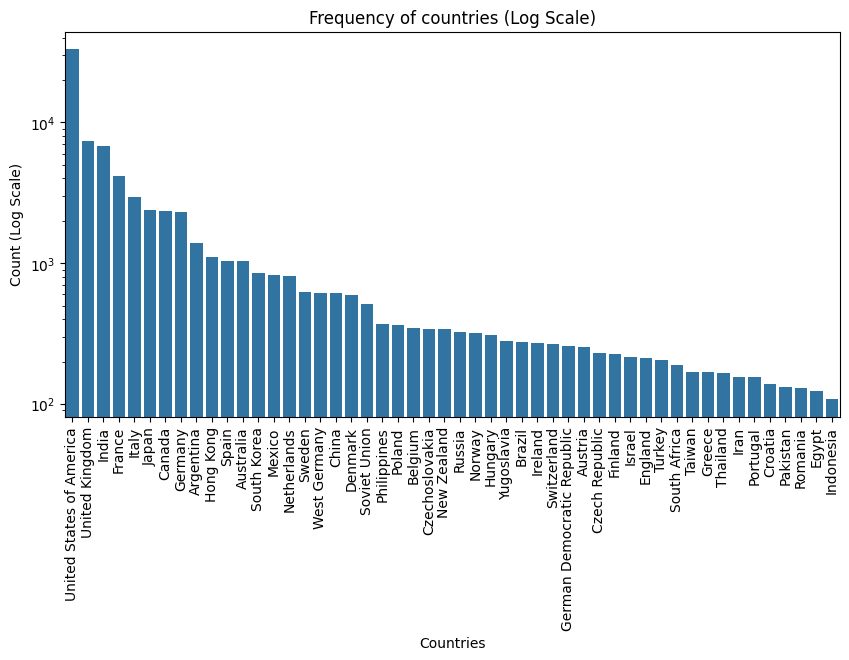

The number of American movies is 33104 which corresponds to 48.59% of the total number of movies.


In [6]:
top_n = 50

countries_counts = preprocessed_movies['Countries'].str.split(', ').explode().value_counts()
top_countries = countries_counts.head(top_n)
top_countries_df = top_countries.reset_index()
top_countries_df.columns = ['Countries', 'Count']

#Using a logarithmic scale
plt.figure(figsize=(10,5))
sns.barplot(x='Countries', y='Count', data=top_countries_df)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Frequency of countries (Log Scale)')
plt.ylabel('Count (Log Scale)')
plt.show()

# show the percentage of english language movies compared to the total number of movies
american_movies = preprocessed_movies['Countries'].str.contains('United States of America').sum()
print(f"The number of American movies is {american_movies} which corresponds to {american_movies/len(preprocessed_movies)*100:.2f}% of the total number of movies.")

As the number of American movies corresponds to half of the worldwide movie industry, we will focus on the the impact of the historical events on genre trends in this country. Let's see what are the main events.

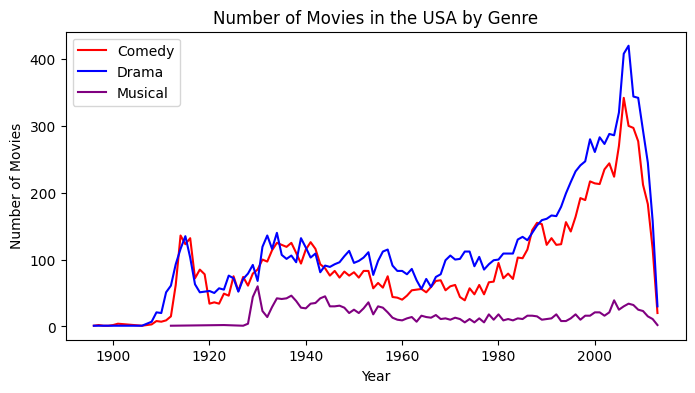

In [7]:
# Define genre categories
genres = {
    "Comedy": ["Comedy", "Comedy-drama", "Adventure Comedy", "Black comedy", "Romantic comedy", 
               "Comedy horror", "Musical comedy", "Screwball comedy", "Comedy Western", "Comedy Thriller"],
    "Drama": ["Drama", "Comedy-drama", "Romantic drama", "Political drama", "Historical drama", 
              "Family Drama", "Melodrama"],
    "Musical": ["Musical", "Musical comedy", "Musical Drama", "Animated Musical"]
}

# Create patterns for each genre
genre_patterns = {key: '|'.join(value) for key, value in genres.items()}

# Function to filter movies by genre and country
def filter_genre_country(df, genre_pattern, country="United States of America"):
    return df[df['Countries'].str.contains(country) & df['Genres'].str.contains(genre_pattern, case=False, na=False)]

# Filter movies for each genre
filtered_data = {genre: filter_genre_country(preprocessed_movies, pattern) for genre, pattern in genre_patterns.items()}

# Group by year and count movies
movies_per_year = {genre: data.groupby('Year').size() for genre, data in filtered_data.items()}

# Plot the data
plt.figure(figsize=(8, 4))
for genre, data in movies_per_year.items():
    plt.plot(data.index, data.values, label=genre, color={'Comedy': 'red', 'Drama': 'blue', 'Musical': 'purple'}[genre])

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in the USA by Genre')
plt.legend()
plt.show()

We can see the rise of musical genre in the 30s.

In [8]:
# events in the USA starting from 1925 to 1930
USA_events = preprocessed_history[preprocessed_history['Country'] == 'United States of America']
USA_events = USA_events[USA_events['Year'].between(1925, 1930)].sort_values(by='Year')
USA_events.head()

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
621,Stock Market Crash of 1929,1929,United States of America,Economic,"Led to the Great Depression, impacting global ...",Global population,Unknown,Negative


Hypothesis: The Great Depression stimulated the rise of musical films due to the need for escapism and entertainment.

The Great Depression, starting with the 1929 stock market crash, led to widespread economic hardship, with unemployment rates exceeding 25% and significant declines in industrial output. In this period of despair, people sought escapism and affordable entertainment to cope with the harsh realities of daily life. However the rise and maintaining of the musical genre is not only due to the need for escapism during the Great Depression, but also because the advent of synchronized sound (The Jazz Singer in 1927) revolutionized the industry, allowing dialogue, music, and dance to be seamlessly integrated into films. Before the late 1920s, films were silent, with music provided by live orchestras. 

### 2) Correlation Between Genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

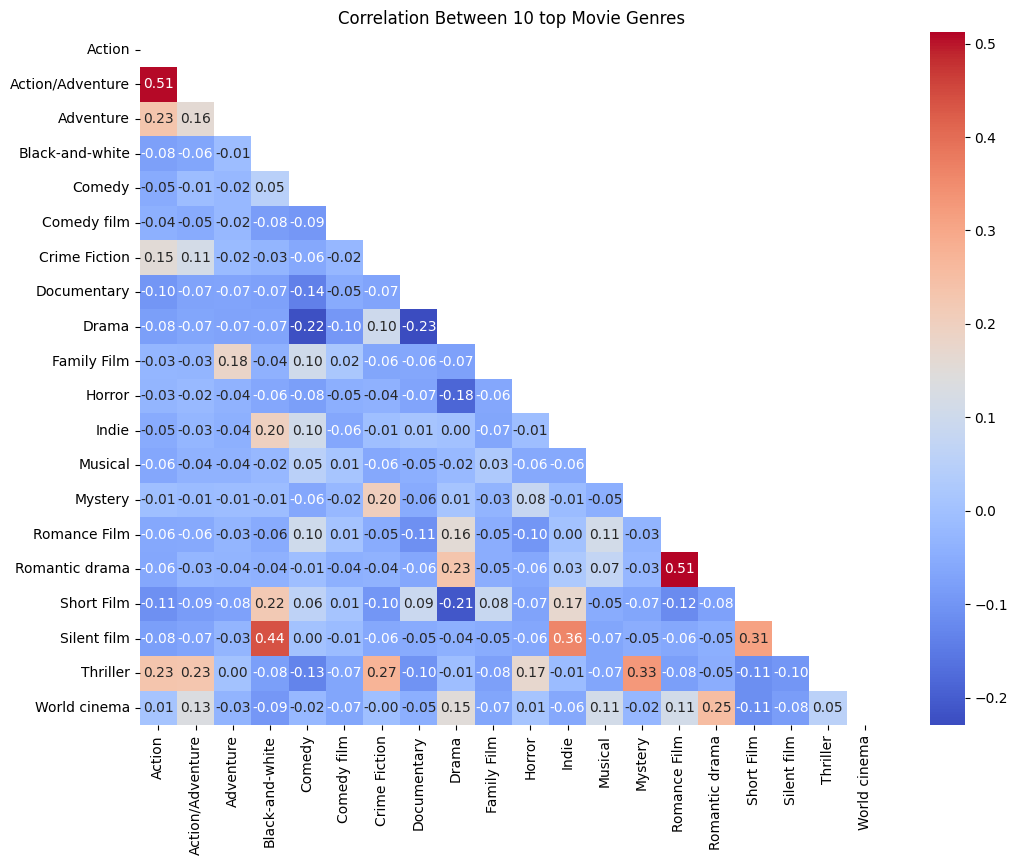

In [9]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']

genre_counts_top_20 = genre_counts.iloc[:20]
most_20commongenres,coverage20 = most_common_genres(preprocessed_movies, genre_counts_top_20, 20)
most_20commongenres = most_20commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_20commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_20commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')
plt.show()

This heatmap illustrates how frequently two genres are used together to describe the same movie.

For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.

On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

We also observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.